In [5]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
!find /content/drive/MyDrive -type f -name "*historical_data*csv"


/content/drive/MyDrive/ds_tanvi_sundarkar/csv_files/historical_data.csv


In [13]:
import pandas as pd
sentiment = pd.read_csv('/content/drive/MyDrive/ds_tanvi_sundarkar/csv_files/fear_greed_index.csv')
traders  = pd.read_csv('/content/drive/MyDrive/ds_tanvi_sundarkar/csv_files/historical_data.csv')


In [15]:
# Normalize column names
traders.columns = traders.columns.str.strip().str.lower().str.replace(' ', '_')

# Quick check
print(traders.columns.tolist())


['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side', 'timestamp_ist', 'start_position', 'direction', 'closed_pnl', 'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id', 'timestamp']


In [16]:
# Convert timestamp to datetime
traders['timestamp_ist'] = pd.to_datetime(traders['timestamp_ist'], format='%d-%m-%Y %H:%M', errors='coerce')

# Create a date column for merging
traders['date'] = traders['timestamp_ist'].dt.date

# Convert numeric fields
numeric_cols = ['execution_price', 'size_tokens', 'size_usd', 'closed_pnl', 'fee', 'start_position']
for col in numeric_cols:
    traders[col] = pd.to_numeric(traders[col], errors='coerce')


In [17]:
# --- Clean Sentiment Dataset ---
sentiment.columns = sentiment.columns.str.strip().str.lower()

# Ensure proper datetime conversion
sentiment['timestamp'] = pd.to_datetime(sentiment['timestamp'], errors='coerce')

# Create a clean date column for joining
sentiment['date'] = pd.to_datetime(sentiment['date'], errors='coerce').dt.date

# Normalize classification (fear/greed)
sentiment['classification'] = sentiment['classification'].str.strip().str.lower()

# Optional: rename columns for consistency
sentiment = sentiment.rename(columns={
    'value': 'sentiment_value',
    'classification': 'sentiment_label'
})

print(sentiment.head())


                      timestamp  sentiment_value sentiment_label        date
0 1970-01-01 00:00:01.517463000               30            fear  2018-02-01
1 1970-01-01 00:00:01.517549400               15    extreme fear  2018-02-02
2 1970-01-01 00:00:01.517635800               40            fear  2018-02-03
3 1970-01-01 00:00:01.517722200               24    extreme fear  2018-02-04
4 1970-01-01 00:00:01.517808600               11    extreme fear  2018-02-05


In [18]:
merged = pd.merge(
    traders,
    sentiment[['date', 'sentiment_label', 'sentiment_value']],
    on='date',
    how='left'
)

print("Merged shape:", merged.shape)
print(merged[['date', 'sentiment_label', 'sentiment_value']].head())


Merged shape: (211224, 19)
         date sentiment_label  sentiment_value
0  2024-12-02   extreme greed             80.0
1  2024-12-02   extreme greed             80.0
2  2024-12-02   extreme greed             80.0
3  2024-12-02   extreme greed             80.0
4  2024-12-02   extreme greed             80.0


In [19]:
daily_stats = merged.groupby(['date', 'sentiment_label']).agg({
    'closed_pnl': ['mean', 'sum'],
    'size_usd': 'sum',
    'fee': 'sum',
    'sentiment_value': 'mean'
}).reset_index()

daily_stats.columns = [
    'Date', 'Sentiment', 'Avg_PnL', 'Total_PnL',
    'Total_Volume', 'Total_Fee', 'Avg_Sentiment_Value'
]

print(daily_stats.head())


         Date      Sentiment    Avg_PnL   Total_PnL  Total_Volume  Total_Fee  \
0  2023-05-01          greed   0.000000    0.000000        477.00   0.000000   
1  2023-12-05  extreme greed   0.000000    0.000000      50005.83  12.501455   
2  2023-12-14          greed -18.675885 -205.434737     113203.35  28.300831   
3  2023-12-15          greed -12.316017  -24.632034      10609.95   2.652489   
4  2023-12-16          greed   0.000000    0.000000      15348.77   3.837189   

   Avg_Sentiment_Value  
0                 63.0  
1                 75.0  
2                 72.0  
3                 70.0  
4                 67.0  


/tmp/ipython-input-1570518580.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sentiment', y='Avg_PnL', data=daily_stats, palette='viridis')


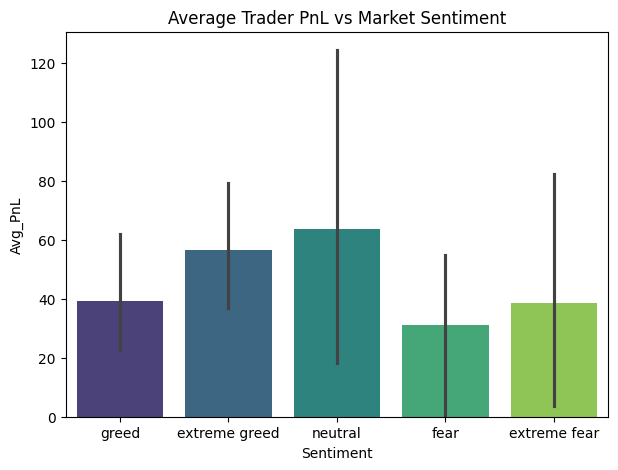

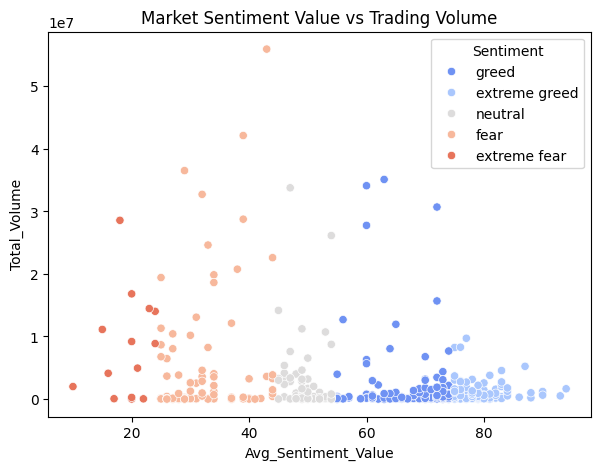

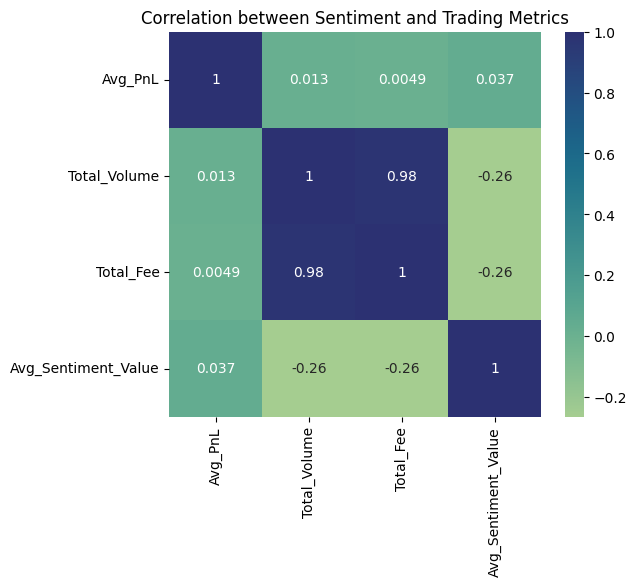

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

os.makedirs('/content/drive/MyDrive/ds_tanvi_sundarkar/outputs', exist_ok=True)

# Avg PnL vs Sentiment
plt.figure(figsize=(7,5))
sns.barplot(x='Sentiment', y='Avg_PnL', data=daily_stats, palette='viridis')
plt.title('Average Trader PnL vs Market Sentiment')
plt.savefig('/content/drive/MyDrive/ds_tanvi_sundarkar/outputs/avg_pnl_vs_sentiment.png', bbox_inches='tight')
plt.show()

# Volume vs Sentiment Value
plt.figure(figsize=(7,5))
sns.scatterplot(x='Avg_Sentiment_Value', y='Total_Volume', hue='Sentiment', data=daily_stats, palette='coolwarm')
plt.title('Market Sentiment Value vs Trading Volume')
plt.savefig('/content/drive/MyDrive/ds_tanvi_sundarkar/outputs/sentiment_vs_volume.png', bbox_inches='tight')
plt.show()

# Correlation Heatmap
plt.figure(figsize=(6,5))
sns.heatmap(daily_stats[['Avg_PnL', 'Total_Volume', 'Total_Fee', 'Avg_Sentiment_Value']].corr(), annot=True, cmap='crest')
plt.title('Correlation between Sentiment and Trading Metrics')
plt.savefig('/content/drive/MyDrive/ds_tanvi_sundarkar/outputs/correlation_heatmap.png', bbox_inches='tight')
plt.show()
